In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import normal
import seaborn as sns
import os

import joblib

import librosa as lb
import librosa.display as ld
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

import sounddevice as sd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# to be changed to new dataset folder with three classes: emergency, non-emergency, alarming
EMERGENCY_PATH = os.path.join("..", "datasets", "emergency")
ALARMING_PATH = os.path.join("..", "datasets", "alarming")
NORMAL_PATH = os.path.join("..", "datasets", "non-emergency")


def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr

#get audio real-time
## def record_audio(duration=5, sample_rate=16000):

In [3]:
def extract_features(audio, sample_rate, max_len=160):
    mfcc = lb.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20, hop_length=512)
    
    zcr = lb.feature.zero_crossing_rate(audio)
    spectral_centroid = lb.feature.spectral_centroid(y=audio, sr=sample_rate)
    spectral_rolloff = lb.feature.spectral_rolloff(y=audio, sr=sample_rate)
    rms = lb.feature.rms(y=audio)
    
    features = [mfcc, spectral_centroid, spectral_rolloff, zcr, rms]
    extracted_features = []

    for feature in features:
        if feature.shape[1] < max_len:
            feature = np.pad(feature, ((0,0),(0, max_len - feature.shape[1])), mode='constant')
        else:
            feature = feature[:, :max_len]
        
        feature_stat = [
            np.mean(feature, axis=1),
            np.std(feature, axis=1),
            np.min(feature, axis=1),
            np.max(feature, axis=1)
        ]
        
        for stat in feature_stat:
            extracted_features.append(stat.flatten())

    return np.concatenate(extracted_features)

In [4]:
def augment_audio(audio, sample_rate):
    augmented = [audio]

    audio_stretched = lb.effects.time_stretch(audio, rate=0.8)
    augmented.append(audio_stretched)

    noise = np.random.normal(0, 0.003, audio.shape)
    audio_noise = audio + noise
    augmented.append(audio_noise)
    
    audio_high_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)
    audio_low_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=-2)
    audio_pitch = np.concatenate((audio_high_pitch, audio_low_pitch))
    augmented.append(audio_pitch)

    noise_bg = np.random.normal(0, 0.001, audio.shape)
    audio_bg = audio + noise_bg
    augmented.append(audio_bg)

    audio_quiet = audio*0.7
    audio_loud = audio*1.3
    audio_volume = np.concatenate((audio_quiet, audio_loud))
    augmented.append(audio_volume)

    return augmented

In [5]:
X = []
y = []
# to be changed with three classes: emergency, non-emergency, alarming
labels = {"emergency": 2, "alarming": 1, "non-emergency": 0}

    # emergency_labels = {"crying sound", "door noise", "glassbreak sounds", "gunshots", "screaming sound"}
    # non_emergency_labels = {"clap", "door sound", "fireworks", "object noise", "toilet noise"}


for label, idx in labels.items():
    
    main_path = EMERGENCY_PATH if label == "emergency" else ALARMING_PATH if label == "alarming" else NORMAL_PATH if label == "non-emergency" else None
    if main_path is None:
        print(f"Warning: No valid path for label {label}. Skipping...")
        continue

    # subfolders =  emergency_labels if label == "emergency" else non_emergency_labels
            
    # for subfolder in subfolders:
    folder = f"{main_path}"

    if not os.path.exists(folder):
        print(f"Warning: Directory {folder} does not exist. Skipping...")
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            try:
                wav, sr = load_audio_files(folder, file)
                augmented_audio = augment_audio(wav, sr)
                for augmented in augmented_audio:
                    features = extract_features(augmented, sr)
                    X.append(features)
                    y.append(idx)

            except Exception as e:
                print(f"Error processing {file} in {folder}: {e}")
                continue

X = np.array(X)
y = np.array(y)

In [6]:
try: 
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
except ValueError as ve:
    print(f"Error during train-test split: {ve}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    unique, counts = np.unique(y, return_counts=True)
    print(f"Class distribution in y: {dict(zip(unique, counts))}")
    raise ve

In [7]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', oob_score=True)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_rfc = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Cross-validation F1 Macro scores: [0.94162963 0.95571684 0.95950235 0.93909385 0.95662899]
Mean CV F1 Macro score: 0.9505143324772177


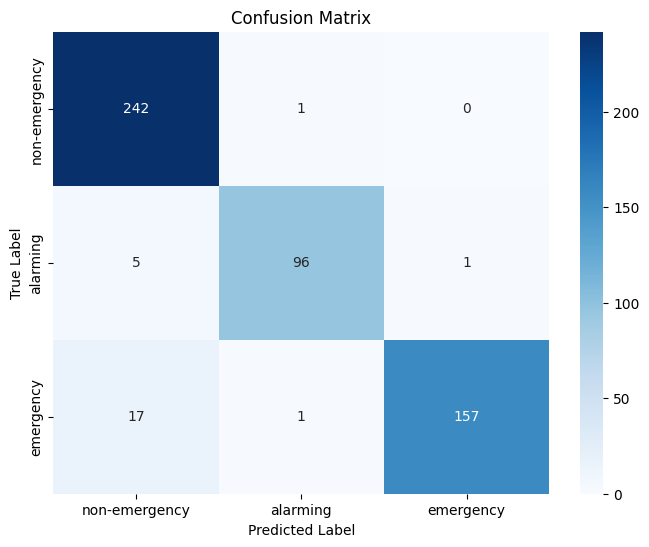

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rfc, X_train, y_train, cv=cv, scoring='f1_macro')
print(f"Cross-validation F1 Macro scores: {cv_scores}")
print(f"Mean CV F1 Macro score: {np.mean(cv_scores)}")

y_pred = best_rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['non-emergency', 'alarming', 'emergency'],
            yticklabels=['non-emergency', 'alarming', 'emergency'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# y_pred = rfc.predict_proba(X_temp)

# threshold = 0.3
# y_pred = (y_pred[:, 1] >= threshold).astype(int)

In [9]:
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["non-emergency", "alarming", "emergency"])

print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:", class_report)

Accuracy: 95.19%
Classification Report:                precision    recall  f1-score   support

non-emergency       0.92      1.00      0.95       243
     alarming       0.98      0.94      0.96       102
    emergency       0.99      0.90      0.94       175

     accuracy                           0.95       520
    macro avg       0.96      0.94      0.95       520
 weighted avg       0.95      0.95      0.95       520



In [10]:
sample_file = "glassbreak_2.wav"

wav, sr = load_audio_files(ALARMING_PATH, sample_file)
augmented_audio = augment_audio(wav, sr)
for augmented in augmented_audio:
    features = extract_features(augmented, sr)

prediction = best_rfc.predict(features.reshape(1, -1))
# prediction = rfc.predict_proba(sample.reshape(1, -1))
# threshold = 0.3
# prediction = (prediction[:, 1] >= threshold).astype(int)

print(f"Prediction for {sample_file}: {'emergency' if prediction[0] == 2 else 'alarming' if prediction[0] == 1 else 'non-emergency'}")

Prediction for glassbreak_2.wav: alarming


In [11]:
joblib.dump(best_rfc, 'mfcc_rf_model.joblib')

['mfcc_rf_model.joblib']